In [1]:
import torch
from agents.debn_ps import *
from environments.env_gridworld import *
from tqdm import tqdm 
from torchsummary import summary
from torch import tensor

### **TEST RUN on AGENT/ENVIRONMENT/DEBN modules**

#### EXPERIMENTS on ENVIRONMENT

In [62]:
envs = TaskEnvironment((10,10)) ##(10x10 rectangular gridworld)

In [63]:
envs.num_percepts_list

(10, 10)

In [64]:
print('pos i:', envs.position )
envs.step(1)
print('pos f:', envs.position )

pos i: [0 0]
pos f: [0 1]


In [65]:
trajectory = []
for _ in tqdm(range(1000)):
    envs.step(np.random.choice([0,1,2,3]))
    trajectory.append(envs.position)


100%|██████████| 1000/1000 [00:00<00:00, 3379.76it/s]


In [66]:
trajectory[-1000::50]

[array([9, 9]),
 array([9, 9]),
 array([9, 9]),
 array([9, 9]),
 array([9, 9]),
 array([9, 9]),
 array([9, 9]),
 array([9, 9]),
 array([9, 9]),
 array([9, 9]),
 array([9, 9]),
 array([9, 9]),
 array([9, 9]),
 array([6, 9]),
 array([6, 9]),
 array([6, 9]),
 array([6, 9]),
 array([6, 9]),
 array([6, 9]),
 array([6, 9])]

#### EXPERIMENTS on DEBN 

In [ ]:
net = DEBN(4,2,dim_hidden_=[10])

In [ ]:
percept = tensor([[1.0,0,0,0]], dtype= float ); action = tensor([[0,1.0]], dtype= float)


In [ ]:
torch.cat((percept, action), dim= 1)

In [ ]:
net.forward(percept, action) ##simple forward pass 

In [ ]:
from torch import nn


In [ ]:
tnet = nn.Linear(2,1)
tnet.weight , tnet.bias

In [ ]:
input = tensor([[1,0]])
input = input.to(torch.float64); print(input)
tnet.forward(input)

#### Experiments on AGENTS

In [2]:
# INTERACTION PARAMETERS #
#------------------------#
EPISODES = 100  # number of episodes for each agent 2000
MAX_STEPS_PER_TRIAL = 50  # number of allowed timesteps before reset 20000

#agent parameters
AGENT_NUMBER = 1
DEVICE = 'cpu'
AGENT_NAME = 'ebm'

GAMMA = 0.99 # discount factor
hidden_layers = 5 # number of hidden layers
hidden_units_layer = 64 # number of hidden units
NUM_HIDDEN = [int(round(hidden_units_layer))]*hidden_layers # list of hidden unit numbers list
DROPOUT = [0.]*hidden_layers # dropout rate list
LEARNING_RATE = 0.001 # learning rate
CAPACITY = 500 # size of the memory
BATCH_SIZE = 100 # size of the training batch for experience replay
REPLAY_TIME = 50 # the time interval between each experience replay
TARGET_UPDATE = 100 # update interval for the target network
SAVE_MODEL = False #set to true to save state dict

BETA_i = 0.001 # initial beta parameter for schedule
BETA_f = 0.08 # final beta parameter for schedule
SCHEDULE = 'htan' # name of the schedule
if SCHEDULE == 'htan':
    beta = np.tanh(np.linspace(BETA_i, BETA_f, EPISODES)) # tanh schedule
elif SCHEDULE =='lin':
    beta = np.linspace(BETA_i, BETA_f, EPISODES) # linear scchedule

# ENVIRONMENT PARAMETERS
ENV_NAME = 'gridworld' # environment name
DIMENSIONS = [10,10] # 2D grid of size [10,10]
env = TaskEnvironment(DIMENSIONS) #generate environment

## 'percept_size' depends on the encdoing 
percept_size_oneh = DIMENSIONS[0]*DIMENSIONS[1] #size of the percept space 
percept_size_twoh = DIMENSIONS[0]+DIMENSIONS[1] #size of the percept space

action_size = 4 # size of the action space

#action encoding
all_actions = torch.empty(0)
for i in range(action_size):
    a = torch.zeros((1, 1, action_size))
    a = a.new_full((1, 1, action_size), 0.)
    a[0, 0, i] = 1.
    all_actions = torch.cat((all_actions, a))

#percept encoding
def to_two_hot(percept, dim):
    """
    Two-hot encodes the 2D percept of positions.
    """
    two_hot = np.zeros(dim[0]+dim[1]) ##added
    two_hot[percept[0]] = 1
    two_hot[dim[0]+percept[1]] = 1
    return two_hot


#percept encoding
def to_one_hot(percept, dim):
    """
    One-hot encodes the 2D percept of positions.
    """
    one_hot = np.zeros(dim[0]*dim[1]) ## multiplied
    
    one_hot[dim[0]*percept[0] + percept[1]] = 1
    
    return one_hot    


In [3]:
# DEFINE AGENT           #
#------------------------#
agent = DEBNAgent(percept_size_twoh, action_size, all_actions, dim_hidden=NUM_HIDDEN, dropout_rate=DROPOUT,
                    device = DEVICE, learning_rate=LEARNING_RATE, capacity=CAPACITY, batch_size=BATCH_SIZE, replay_time=REPLAY_TIME,
                    target_update = TARGET_UPDATE, gamma = GAMMA, train_output_weights = False)


In [4]:
counter = 0
#reset the environment
percept = env.reset()
percept = to_two_hot(percept,DIMENSIONS)
percept = np.reshape(percept, [1, percept_size_twoh])
percept = torch.Tensor(percept)
reward = 0.
done = False

In [5]:
agent.deliberate(percept, 1)

tensor([[0., 0., 1., 0.]])

In [6]:
action = agent.deliberate_and_learn(percept, None, reward, GAMMA, done, 1.00)
action = (action[0] == 1).nonzero().item()

In [7]:
env.step(action)

(array([0, 1]), 0.0, False, None)

In [8]:
agent._memory ## memory can only be accessed by the -> ._experience_replay function.

deque([])

In [4]:
EPISODES = 100
MAX_STEPS_PER_TRIAL = 100
verbose = False
coords = []
# RUN TRAINING STEPS     #
#------------------------#
timesteps = []
for e in tqdm(range(EPISODES), desc= 'running episodes'):
    counter = 0
    #reset the environment
    percept = env.reset()
    coords.append(percept) ## coords stroing 
    # percept = to_one_hot(percept,DIMENSIONS)
    # percept = np.reshape(percept, [1, percept_size_oneh])
    percept = to_two_hot(percept,DIMENSIONS)
    percept = np.reshape(percept, [1, percept_size_twoh])
    percept = torch.Tensor(percept)
    reward = 0.
    done = False
    # for t in tqdm(range(1, MAX_STEPS_PER_TRIAL + 1), desc= 'runnnig episode . .. '+str(e) ):
    for t in range(1, MAX_STEPS_PER_TRIAL + 1):
        
        action = agent.deliberate_and_learn(percept, None, reward, GAMMA, done, beta[e])
        action = (action[0] == 1).nonzero().item()
        percept, reward, done, _ = env.step(action)
        coords.append(percept) ## coords storing 

        if verbose :  print('action : '+str( action) + ' percept : ' + str(percept) + ' reward : '+ str( reward))
        # percept = to_one_hot(percept, DIMENSIONS)
        # percept = np.reshape(percept, [1, percept_size_oneh])
        percept = to_two_hot(percept,DIMENSIONS)
        percept = np.reshape(percept, [1, percept_size_twoh])
        percept = torch.Tensor(percept)
        
        if t==MAX_STEPS_PER_TRIAL:
            reward = -1
            done = True
        if done:
            agent.deliberate_and_learn(percept, None, reward, GAMMA, done, beta[e])
            timesteps.append(t)
            break

    if e%100 == 0:
        if verbose : print("Average last 100 scores (timesteps per episode) the agent achieved at " + str(e) + ": ", np.mean(timesteps[-100:]))
        # save data to file


running episodes: 100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


In [5]:
xs = []; ys = []
for coord in coords: 
    xs.append(coord[0])
    ys.append(coord[1])

In [15]:
import matplotlib
%matplotlib inline 
import  matplotlib.pyplot as plt
from IPython.display import display, clear_output


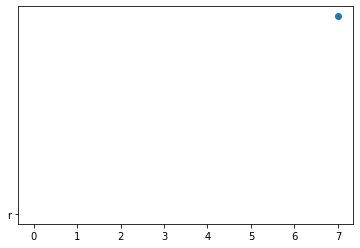

100%|██████████| 200/200 [00:34<00:00,  5.86it/s]


In [21]:
## visualise trajectory dynamically ## not very efficeint
plt.figure(figsize=(12,12))
for coord in tqdm(coords[::50]) :
    plt.plot(coord[0], coord[1], 'o', 'r')
    clear_output(wait= True)
    plt.show()
# plt.scatter(xs, ys )


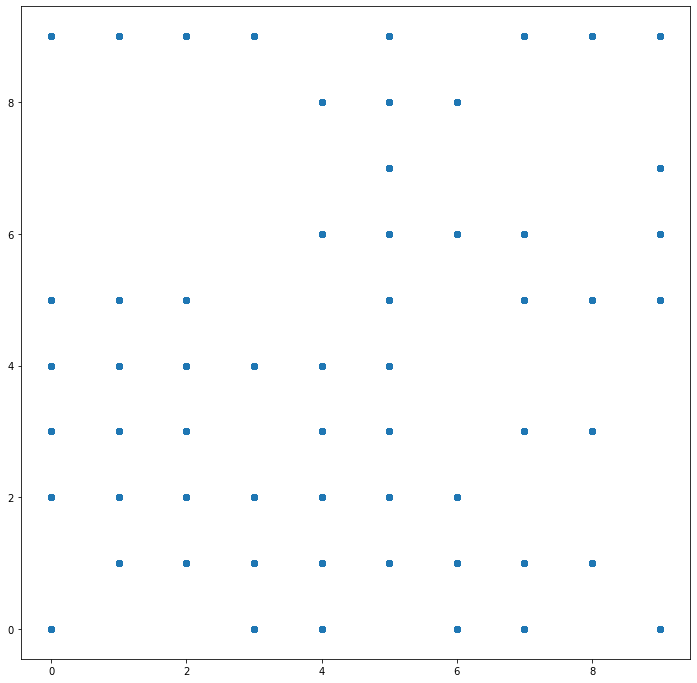

In [8]:
## visualise spots visited  ##
plt.figure(figsize=(12,12))
# for coord in tqdm(coords) :
#     plt.plot(xs, ys, '-o', 'r')
plt.scatter(xs, ys )
plt.show()

In [ ]:
plt.scatter( )